## 1. Setup and Imports

In [1]:
import os
import sys
from pathlib import Path
import shutil

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import yaml
from tqdm import tqdm

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set project root
PROJECT_ROOT = Path(r"c:/Users/anike/Downloads/WasteSegregation")
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project Root: {PROJECT_ROOT}")
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print("\n✅ Imports successful!")

Project Root: c:\Users\anike\Downloads\WasteSegregation
TensorFlow Version: 2.20.0
GPU Available: False

✅ Imports successful!


In [2]:
# Load configuration
config_path = PROJECT_ROOT / "config" / "config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Define paths
PROCESSED_DATA_PATH = PROJECT_ROOT / "datasets" / "processed"
MODELS_PATH = PROJECT_ROOT / "models" / "mobilenet"
MODELS_PATH.mkdir(parents=True, exist_ok=True)

# Classification configuration
MOBILENET_CONFIG = config['mobilenet']
DATASET_CONFIG = config['dataset']

# Image settings
IMG_SIZE = (DATASET_CONFIG['image_size'], DATASET_CONFIG['image_size'])  # 224x224
BATCH_SIZE = MOBILENET_CONFIG['batch_size']
EPOCHS = 10  # Reduced for CPU training

# Class names - from categories.classification in config
CLASS_NAMES = config['categories']['classification']
NUM_CLASSES = len(CLASS_NAMES)

print("📋 MobileNet Classification Configuration:")
print("=" * 50)
print(f"   Image Size: {IMG_SIZE}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Classes: {CLASS_NAMES}")
print(f"   Number of Classes: {NUM_CLASSES}")

📋 MobileNet Classification Configuration:
   Image Size: (224, 224)
   Batch Size: 32
   Epochs: 10
   Classes: ['recyclable', 'organic', 'e-waste', 'general']
   Number of Classes: 4


## 2. Verify Dataset Structure

In [3]:
# Check classification dataset
print("📁 Classification Dataset Structure:\n")

splits = ['train', 'val', 'test']
dataset_stats = {}

for split in splits:
    split_path = PROCESSED_DATA_PATH / split / "classification"
    print(f"📂 {split.upper()}:")
    
    if split_path.exists():
        split_stats = {}
        for category in CLASS_NAMES:
            cat_path = split_path / category
            if cat_path.exists():
                count = len(list(cat_path.glob("*.jpg")))
                split_stats[category] = count
                print(f"   {category}: {count} images")
            else:
                print(f"   {category}: ❌ Not found")
        dataset_stats[split] = split_stats
    else:
        print(f"   ❌ Path not found: {split_path}")
    print()

📁 Classification Dataset Structure:

📂 TRAIN:
   recyclable: 1824 images
   organic: 1 images
   e-waste: 1 images
   general: 306 images

📂 VAL:
   recyclable: 385 images
   organic: 0 images
   e-waste: 0 images
   general: 61 images

📂 TEST:
   recyclable: 384 images
   organic: 0 images
   e-waste: 0 images
   general: 65 images



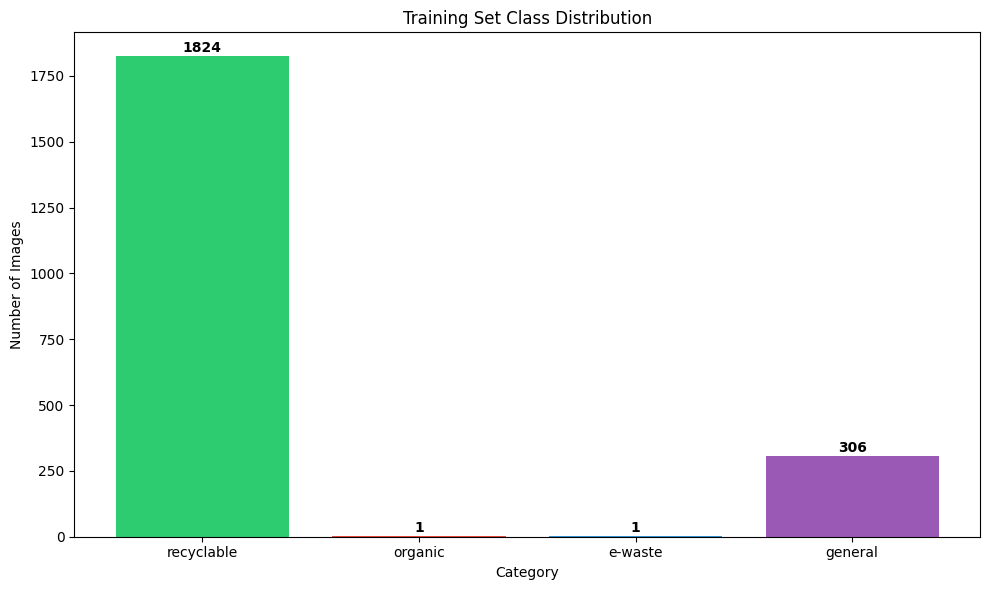

In [4]:
# Visualize class distribution
if 'train' in dataset_stats:
    train_stats = dataset_stats['train']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6']
    bars = ax.bar(train_stats.keys(), train_stats.values(), color=colors)
    
    ax.set_xlabel('Category')
    ax.set_ylabel('Number of Images')
    ax.set_title('Training Set Class Distribution')
    
    # Add count labels
    for bar, count in zip(bars, train_stats.values()):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## 3. Create Data Generators

In [5]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation/test
val_datagen = ImageDataGenerator(rescale=1./255)

print("📊 Creating data generators...\n")

# Training generator
train_generator = train_datagen.flow_from_directory(
    PROCESSED_DATA_PATH / "train" / "classification",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=True
)

# Validation generator
val_generator = val_datagen.flow_from_directory(
    PROCESSED_DATA_PATH / "val" / "classification",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False
)

# Test generator
test_generator = val_datagen.flow_from_directory(
    PROCESSED_DATA_PATH / "test" / "classification",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False
)

print(f"\n✅ Data generators created!")
print(f"   Training samples: {train_generator.samples}")
print(f"   Validation samples: {val_generator.samples}")
print(f"   Test samples: {test_generator.samples}")
print(f"   Class indices: {train_generator.class_indices}")

📊 Creating data generators...

Found 2132 images belonging to 4 classes.
Found 446 images belonging to 4 classes.
Found 449 images belonging to 4 classes.

✅ Data generators created!
   Training samples: 2132
   Validation samples: 446
   Test samples: 449
   Class indices: {'recyclable': 0, 'organic': 1, 'e-waste': 2, 'general': 3}


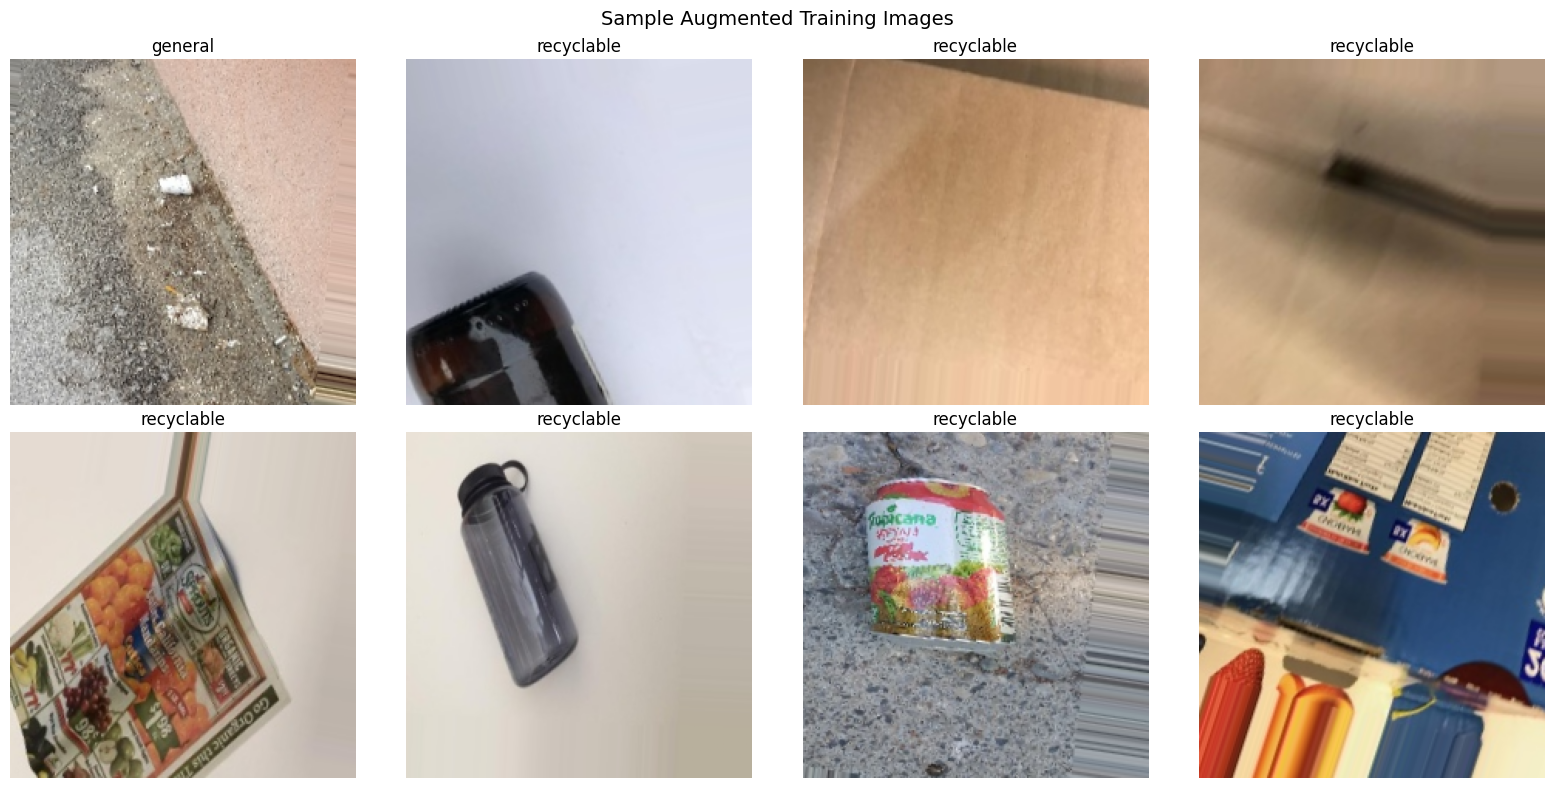

In [6]:
# Visualize sample augmented images
sample_batch, sample_labels = next(train_generator)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, (img, label) in enumerate(zip(sample_batch[:8], sample_labels[:8])):
    axes[i].imshow(img)
    class_idx = np.argmax(label)
    axes[i].set_title(f"{CLASS_NAMES[class_idx]}")
    axes[i].axis('off')

plt.suptitle('Sample Augmented Training Images', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Build MobileNetV2 Model

In [7]:
def create_mobilenet_model(num_classes, input_shape=(224, 224, 3)):
    """
    Create a MobileNetV2-based classification model.
    Uses transfer learning with ImageNet weights.
    """
    # Load pretrained MobileNetV2
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model layers initially
    base_model.trainable = False
    
    # Build classification head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model, base_model


# Create model
print("🔄 Building MobileNetV2 model...")
model, base_model = create_mobilenet_model(NUM_CLASSES, input_shape=(*IMG_SIZE, 3))

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model created and compiled!")
model.summary()

🔄 Building MobileNetV2 model...

✅ Model created and compiled!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,428,100 (9.26 MB)

 Trainable params: 167,300 (653.52 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

## 5. Train Model (Transfer Learning)

In [8]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        str(MODELS_PATH / 'mobilenet_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

print("📋 Training Callbacks:")
print("   • EarlyStopping (patience=3)")
print("   • ModelCheckpoint (save best)")
print("   • ReduceLROnPlateau (factor=0.5)")

📋 Training Callbacks:
   • EarlyStopping (patience=3)
   • ModelCheckpoint (save best)
   • ReduceLROnPlateau (factor=0.5)


In [9]:
# Phase 1: Train only the classification head (frozen base)
print("🚀 Phase 1: Training Classification Head")
print("=" * 50)
print(f"⏳ Training for {EPOCHS} epochs (base model frozen)...")
print("=" * 50 + "\n")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "=" * 50)
print("✅ Phase 1 training complete!")
print("=" * 50)

🚀 Phase 1: Training Classification Head
⏳ Training for 10 epochs (base model frozen)...

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.4958 - loss: 1.5899
Epoch 1: val_accuracy improved from None to 0.84305, saving model to c:\Users\anike\Downloads\WasteSegregation\models\mobilenet\mobilenet_best.keras

Epoch 1: finished saving model to c:\Users\anike\Downloads\WasteSegregation\models\mobilenet\mobilenet_best.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 48s 625ms/step - accuracy: 0.5882 - loss: 1.3859 - val_accuracy: 0.8430 - val_loss: 0.7385 - learning_rate: 0.0010
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.7598 - loss: 0.8696
Epoch 2: val_accuracy improved from 0.84305 to 0.90807, saving model to c:\Users\anike\Downloads\WasteSegregation\models\mobilenet\mobilenet_best.keras

Epoch 2: finished saving model to c:\Users\anike\Downloads\WasteSegregation\models\mobilenet\mobilenet_best.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 34s 498ms/step - accuracy: 0.7735 - los

In [10]:
# Phase 2: Fine-tune the model (unfreeze some layers)
print("🔓 Unfreezing top layers for fine-tuning...")

# Unfreeze the top 30 layers
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n🚀 Phase 2: Fine-Tuning")
print("=" * 50)
print(f"⏳ Fine-tuning for 5 more epochs...")
print("=" * 50 + "\n")

history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "=" * 50)
print("✅ Fine-tuning complete!")
print("=" * 50)

🔓 Unfreezing top layers for fine-tuning...

🚀 Phase 2: Fine-Tuning
⏳ Fine-tuning for 5 more epochs...

Epoch 1/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.8989 - loss: 0.2695
Epoch 1: val_accuracy improved from 0.93049 to 0.93274, saving model to c:\Users\anike\Downloads\WasteSegregation\models\mobilenet\mobilenet_best.keras

Epoch 1: finished saving model to c:\Users\anike\Downloads\WasteSegregation\models\mobilenet\mobilenet_best.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 53s 659ms/step - accuracy: 0.9085 - loss: 0.2523 - val_accuracy: 0.9327 - val_loss: 0.2051 - learning_rate: 1.0000e-04
Epoch 2/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.9308 - loss: 0.2015
Epoch 2: val_accuracy improved from 0.93274 to 0.93722, saving model to c:\Users\anike\Downloads\WasteSegregation\models\mobilenet\mobilenet_best.keras

Epoch 2: finished saving model to c:\Users\anike\Downloads\WasteSegregation\models\mobilenet\mobilenet_best.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 46s 686ms/step - acc

## 6. Evaluate Model

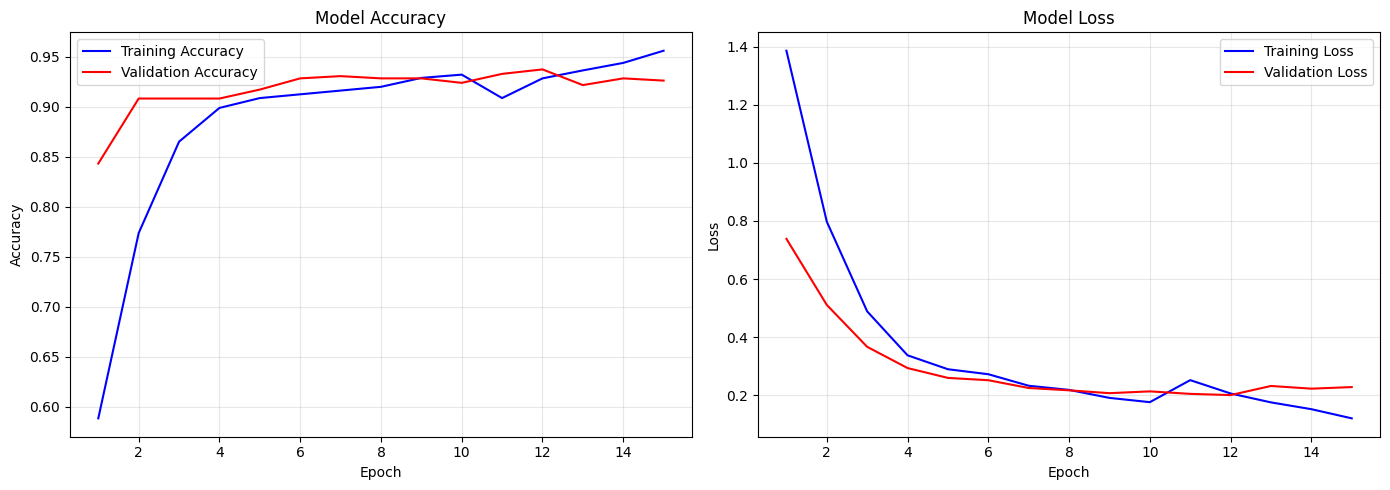

In [11]:
# Plot training history
def plot_training_history(history, history_fine=None):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Combine histories if fine-tuning was done
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    if history_fine:
        acc += history_fine.history['accuracy']
        val_acc += history_fine.history['val_accuracy']
        loss += history_fine.history['loss']
        val_loss += history_fine.history['val_loss']
    
    epochs_range = range(1, len(acc) + 1)
    
    # Accuracy plot
    axes[0].plot(epochs_range, acc, 'b-', label='Training Accuracy')
    axes[0].plot(epochs_range, val_acc, 'r-', label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[1].plot(epochs_range, loss, 'b-', label='Training Loss')
    axes[1].plot(epochs_range, val_loss, 'r-', label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history, history_fine)

In [12]:
# Evaluate on test set
print("📊 Evaluating model on test set...")
print("=" * 50)

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print("\n📈 Test Results:")
print("=" * 50)
print(f"   Test Loss: {test_loss:.4f}")
print(f"   Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")

📊 Evaluating model on test set...
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 407ms/step - accuracy: 0.9265 - loss: 0.2145

📈 Test Results:
   Test Loss: 0.2145
   Test Accuracy: 0.9265 (92.7%)


15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 454ms/step
Classes present in test data: ['recyclable', 'general']
Unique class indices: [0 3]


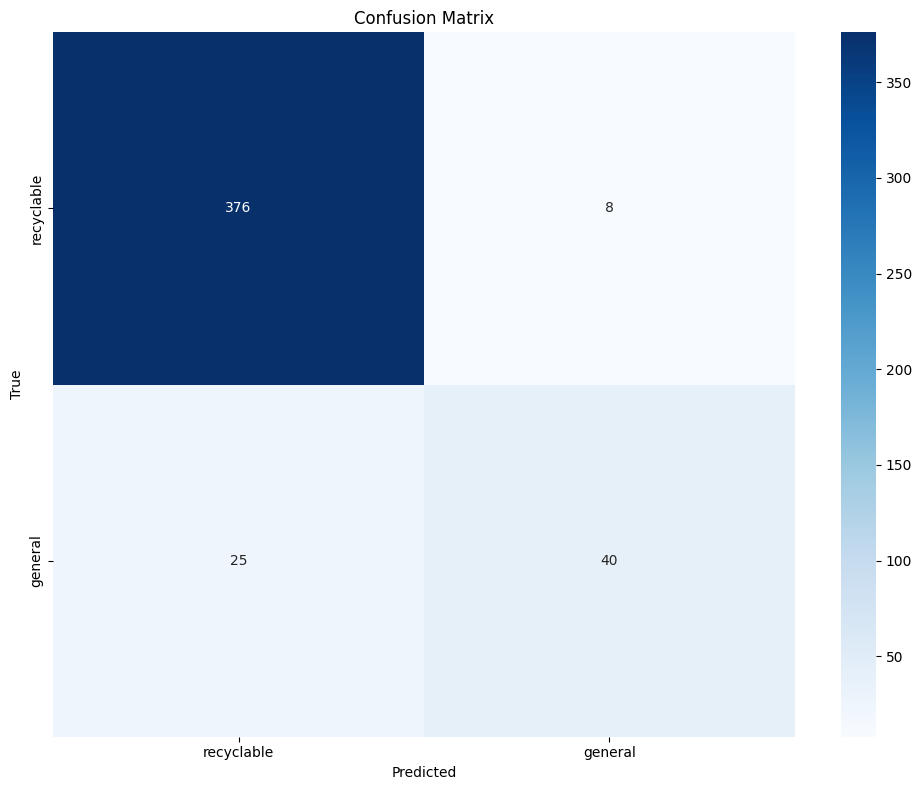


📋 Classification Report:
              precision    recall  f1-score   support

  recyclable       0.94      0.98      0.96       384
     general       0.83      0.62      0.71        65

    accuracy                           0.93       449
   macro avg       0.89      0.80      0.83       449
weighted avg       0.92      0.93      0.92       449



In [13]:
# Generate predictions for confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Get unique classes present in the data
unique_classes = np.unique(np.concatenate([true_classes, predicted_classes]))
present_class_names = [CLASS_NAMES[i] for i in unique_classes]

print(f"Classes present in test data: {present_class_names}")
print(f"Unique class indices: {unique_classes}")

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes, labels=unique_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=present_class_names, yticklabels=present_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Classification report with labels parameter
print("\n📋 Classification Report:")
print("=" * 50)
print(classification_report(true_classes, predicted_classes, 
                            labels=unique_classes, 
                            target_names=present_class_names))

## 7. Test on Sample Images

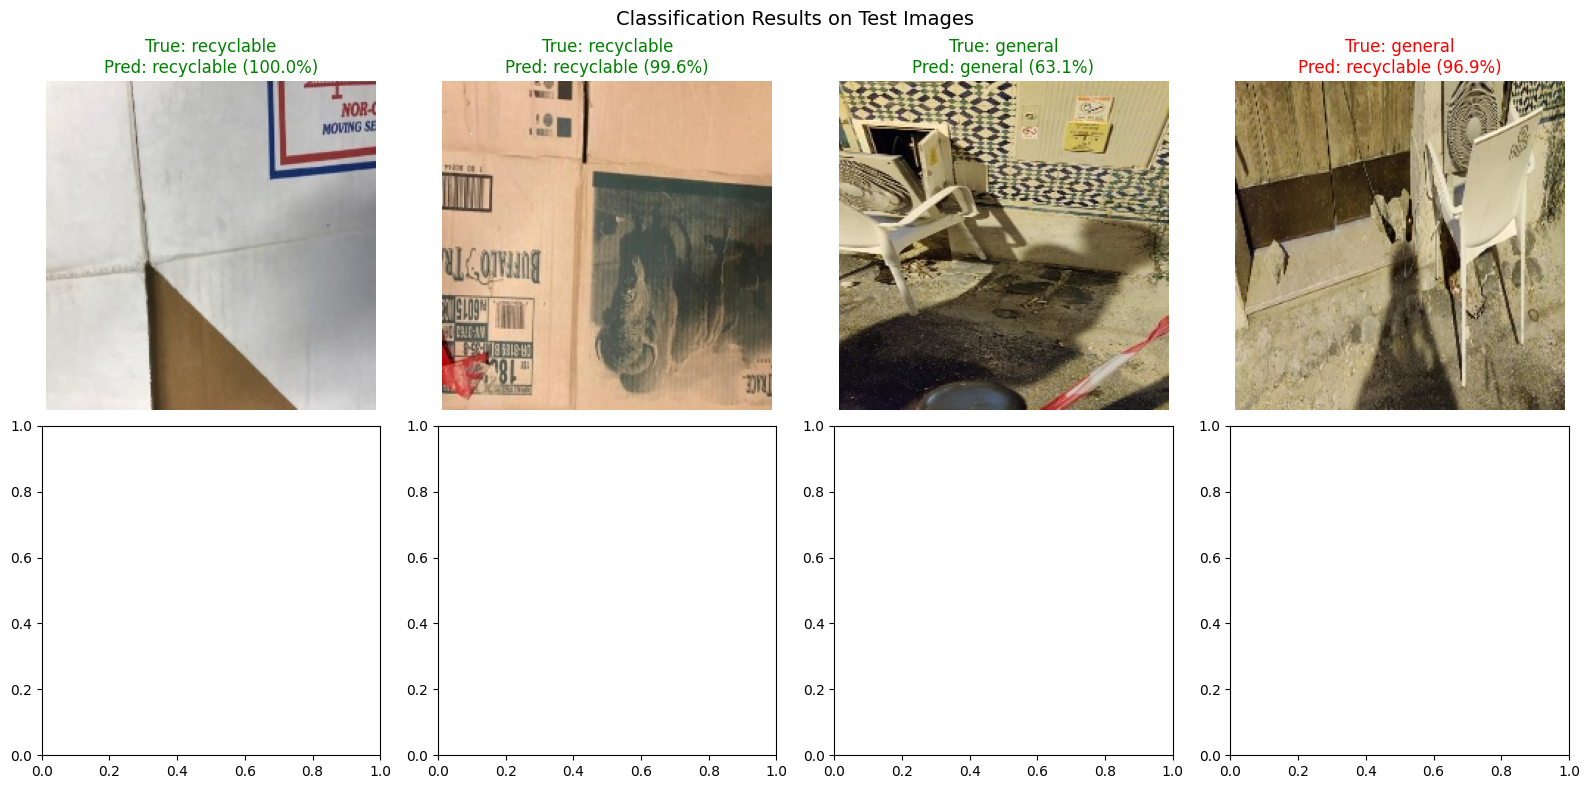

In [14]:
def predict_image(model, image_path, class_names):
    """
    Predict the class of a single image.
    """
    # Load and preprocess image
    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict
    predictions = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]
    
    return class_names[predicted_class], confidence, predictions[0]


# Test on random samples from each class
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

test_base = PROCESSED_DATA_PATH / "test" / "classification"
sample_idx = 0

for category in CLASS_NAMES:
    cat_path = test_base / category
    if cat_path.exists():
        images = list(cat_path.glob("*.jpg"))[:2]
        for img_path in images:
            if sample_idx < 8:
                pred_class, confidence, probs = predict_image(model, img_path, CLASS_NAMES)
                
                img = Image.open(img_path)
                axes[sample_idx].imshow(img)
                
                color = 'green' if pred_class == category else 'red'
                axes[sample_idx].set_title(
                    f"True: {category}\nPred: {pred_class} ({confidence:.1%})",
                    color=color
                )
                axes[sample_idx].axis('off')
                sample_idx += 1

plt.suptitle('Classification Results on Test Images', fontsize=14)
plt.tight_layout()
plt.show()

## 8. Save Model and Create Utility

In [15]:
# Save final model
final_model_path = MODELS_PATH / "waste_classifier_final.keras"
model.save(str(final_model_path))
print(f"✅ Model saved to: {final_model_path}")

# Also save in H5 format for compatibility
h5_path = MODELS_PATH / "waste_classifier_final.h5"
model.save(str(h5_path))
print(f"✅ H5 model saved to: {h5_path}")

# Save class names mapping
class_mapping = {i: name for i, name in enumerate(CLASS_NAMES)}
mapping_path = MODELS_PATH / "class_mapping.yaml"
with open(mapping_path, 'w') as f:
    yaml.dump(class_mapping, f)
print(f"✅ Class mapping saved to: {mapping_path}")

✅ Model saved to: c:\Users\anike\Downloads\WasteSegregation\models\mobilenet\waste_classifier_final.keras
✅ H5 model saved to: c:\Users\anike\Downloads\WasteSegregation\models\mobilenet\waste_classifier_final.h5
✅ Class mapping saved to: c:\Users\anike\Downloads\WasteSegregation\models\mobilenet\class_mapping.yaml


In [16]:
# Create classifier utility module
classifier_utils_code = '''
"""
MobileNet Classification Utilities for Waste Segregation System
"""

import numpy as np
from pathlib import Path
import yaml

import tensorflow as tf
from tensorflow import keras


class WasteClassifier:
    """
    Waste category classifier using MobileNetV2.
    """
    
    def __init__(self, model_path, class_mapping_path=None, image_size=(224, 224)):
        """
        Initialize the waste classifier.
        
        Args:
            model_path: Path to the trained Keras model
            class_mapping_path: Path to class mapping YAML file
            image_size: Input image size (height, width)
        """
        self.model = keras.models.load_model(str(model_path))
        self.image_size = image_size
        
        # Load class mapping
        if class_mapping_path and Path(class_mapping_path).exists():
            with open(class_mapping_path, "r") as f:
                self.class_names = yaml.safe_load(f)
        else:
            self.class_names = {0: "recyclable", 1: "organic", 2: "e-waste", 3: "general"}
    
    def preprocess_image(self, image):
        """
        Preprocess image for classification.
        
        Args:
            image: numpy array (BGR or RGB) or path to image
            
        Returns:
            Preprocessed image array
        """
        import cv2
        
        if isinstance(image, (str, Path)):
            img = cv2.imread(str(image))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img = image.copy()
            if img.shape[-1] == 3 and len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img = cv2.resize(img, self.image_size)
        img = img.astype(np.float32) / 255.0
        
        return img
    
    def classify(self, image):
        """
        Classify a waste image.
        
        Args:
            image: Image path or numpy array
            
        Returns:
            Dictionary with class name, confidence, and all probabilities
        """
        img = self.preprocess_image(image)
        img = np.expand_dims(img, axis=0)
        
        predictions = self.model.predict(img, verbose=0)
        predicted_class = np.argmax(predictions[0])
        confidence = float(predictions[0][predicted_class])
        
        return {
            "class_id": int(predicted_class),
            "class_name": self.class_names[predicted_class],
            "confidence": confidence,
            "probabilities": {self.class_names[i]: float(p) for i, p in enumerate(predictions[0])}
        }
    
    def classify_batch(self, images):
        """
        Classify multiple images.
        
        Args:
            images: List of image paths or numpy arrays
            
        Returns:
            List of classification results
        """
        results = []
        for img in images:
            results.append(self.classify(img))
        return results
'''

# Save the utility module
utils_path = PROJECT_ROOT / "src" / "classifier.py"
with open(utils_path, 'w') as f:
    f.write(classifier_utils_code)

print(f"✅ Classifier utilities saved to: {utils_path}")

✅ Classifier utilities saved to: c:\Users\anike\Downloads\WasteSegregation\src\classifier.py


## 9. Phase 4 Summary

In [17]:
print("=" * 60)
print("🎉 PHASE 4 COMPLETE: MOBILENET CLASSIFICATION TRAINING")
print("=" * 60)

print("\n📦 MODEL DETAILS:")
print(f"   • Base Model: MobileNetV2 (ImageNet pretrained)")
print(f"   • Input Size: {IMG_SIZE[0]}x{IMG_SIZE[1]}")
print(f"   • Classes: {CLASS_NAMES}")
print(f"   • Training: Transfer Learning + Fine-tuning")

print("\n📈 PERFORMANCE METRICS:")
print(f"   • Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print(f"   • Test Loss: {test_loss:.4f}")

print("\n📁 SAVED FILES:")
print(f"   • Keras Model: {MODELS_PATH / 'waste_classifier_final.keras'}")
print(f"   • H5 Model: {MODELS_PATH / 'waste_classifier_final.h5'}")
print(f"   • Class Mapping: {MODELS_PATH / 'class_mapping.yaml'}")
print(f"   • Classifier Module: {PROJECT_ROOT / 'src' / 'classifier.py'}")

print("\n✅ NEXT STEPS:")
print("   1. Phase 5: Train Autoencoder for anomaly detection")
print("   2. Phase 6: Integrate all models into pipeline")

print("\n" + "=" * 60)

🎉 PHASE 4 COMPLETE: MOBILENET CLASSIFICATION TRAINING

📦 MODEL DETAILS:
   • Base Model: MobileNetV2 (ImageNet pretrained)
   • Input Size: 224x224
   • Classes: ['recyclable', 'organic', 'e-waste', 'general']
   • Training: Transfer Learning + Fine-tuning

📈 PERFORMANCE METRICS:
   • Test Accuracy: 0.9265 (92.7%)
   • Test Loss: 0.2145

📁 SAVED FILES:
   • Keras Model: c:\Users\anike\Downloads\WasteSegregation\models\mobilenet\waste_classifier_final.keras
   • H5 Model: c:\Users\anike\Downloads\WasteSegregation\models\mobilenet\waste_classifier_final.h5
   • Class Mapping: c:\Users\anike\Downloads\WasteSegregation\models\mobilenet\class_mapping.yaml
   • Classifier Module: c:\Users\anike\Downloads\WasteSegregation\src\classifier.py

✅ NEXT STEPS:
   1. Phase 5: Train Autoencoder for anomaly detection
   2. Phase 6: Integrate all models into pipeline

